[[[0.00222546 0.0012154  0.00944065 ... 0.0745673  0.07329551 0.07219315]
  [0.00387025 0.00084509 0.0137941  ... 0.07452324 0.07329551 0.07202625]
  [0.0008955  0.01085883 0.02656115 ... 0.07355398 0.07279113 0.07147789]
  ...
  [0.00766826 0.01031892 0.01309737 ... 0.01619113 0.01720622 0.01784563]
  [0.00374544 0.00960825 0.01532972 ... 0.01664272 0.0170572  0.01772642]
  [0.004006   0.00988667 0.0166018  ... 0.01666475 0.01737817 0.01792908]]

 [[0.00040179 0.00276645 0.0135023  ... 0.07452324 0.07370818 0.07181168]
  [0.00211573 0.0041972  0.01717066 ... 0.0745673  0.07297454 0.0718832 ]
  [0.00228292 0.01297281 0.02826145 ... 0.07377427 0.07260772 0.07097721]
  ...
  [0.00266704 0.00641174 0.01016689 ... 0.01633431 0.01687379 0.01790524]
  [0.00481021 0.00988128 0.01487697 ... 0.01648852 0.01735524 0.01804829]
  [0.00612962 0.0116052  0.01711786 ... 0.01664272 0.01743548 0.01789331]]

 [[0.00887907 0.01315659 0.02387418 ... 0.07443513 0.07299746 0.07183552]
  [0.00440633 0.012900

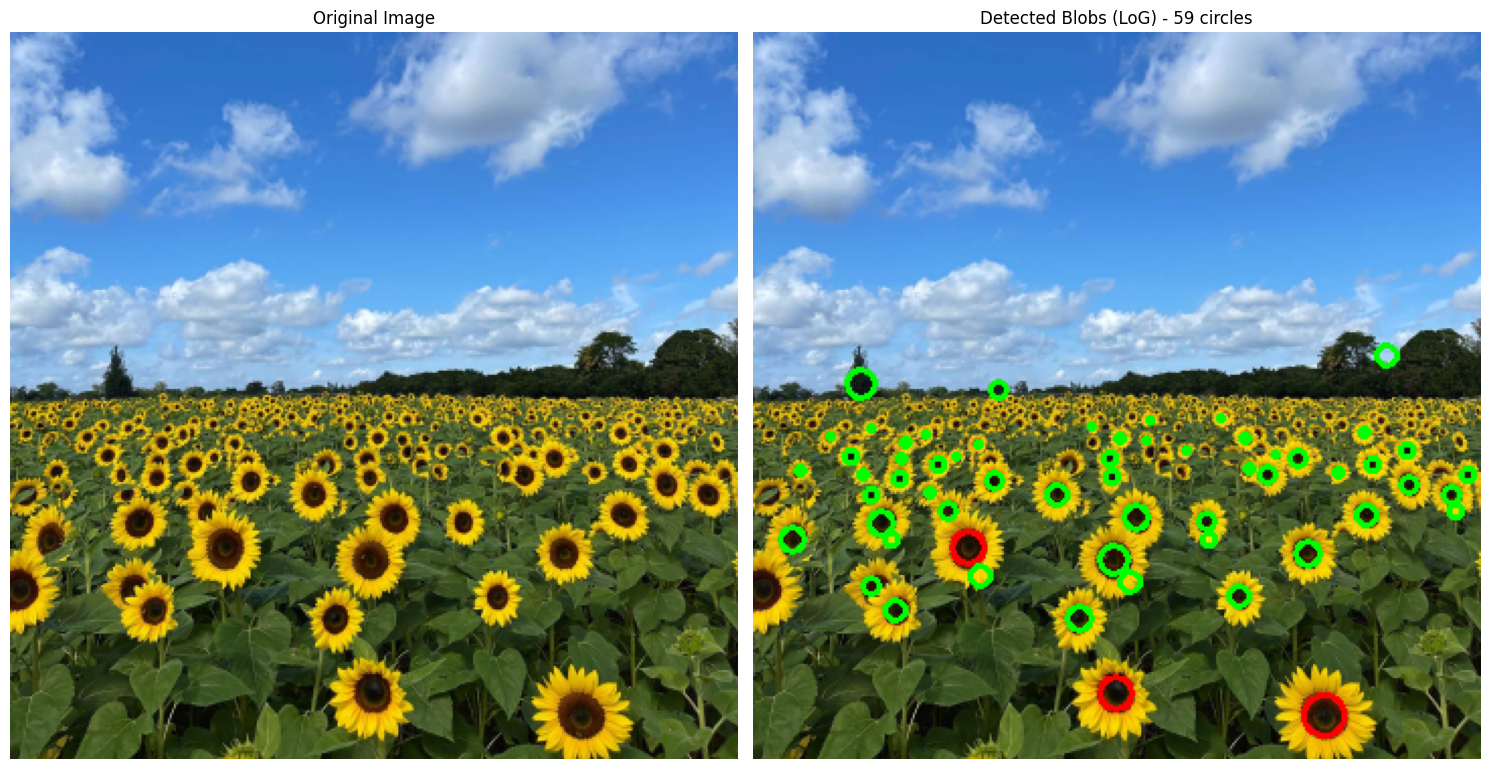


=== RESULTS ===
Range of σ values used: 1 to 20
Number of scales: 50

Top 10 Largest Circles:
Rank   X        Y        Sigma      Radius     Response  
------------------------------------------------------------
1      282.0    338.0    7.20       10.19      0.3499    
2      106.0    255.0    6.04       8.54       0.3624    
3      179.0    327.0    6.04       8.54       0.3449    
4      178.0    261.0    5.65       7.99       0.3516    
5      53.0     174.0    5.65       7.99       0.3015    
6      189.0    240.0    4.49       6.35       0.3630    
7      161.0    290.0    4.49       6.35       0.3620    
8      63.0     243.0    4.49       6.35       0.3559    
9      274.0    258.0    4.49       6.35       0.3444    
10     19.0     251.0    4.49       6.35       0.2912    


In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

im = cv.imread("the_berry_farms_sunflower_field.jpeg", cv.IMREAD_REDUCED_COLOR_4)
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
gray = gray.astype(np.float32) / 255.0

sigma_min = 1
sigma_max = 20
num_scales = 50
sigma_values = np.linspace(sigma_min, sigma_max, num_scales) #linear spacing of values from 1 to 21

log_responses = []

for sigma in sigma_values:
    blurred = cv.GaussianBlur(gray, (0, 0), sigma)
    laplacian = cv.Laplacian(blurred, cv.CV_32F)
    log_normalized = (sigma ** 2) * np.abs(laplacian) #scale normalize the laplacian
    log_responses.append(log_normalized)

log_stack = np.stack(log_responses, axis=2)
print(log_stack)
print(log_stack.shape)

print("Finding scale-space extrema...")
threshold = 0.28


blob_candidates = []

# Use non-maximum suppression in 3D
for s in range(1, num_scales - 1):
    for y in range(5, gray.shape[0] - 5):
        for x in range(5, gray.shape[1] - 5):
            
            # Get local neighborhood (3x3x3)
            local_region = log_stack[y-1:y+2, x-1:x+2, s-1:s+2]
            center_value = log_stack[y, x, s]
            
            # Check if it's a local maximum and above threshold
            if center_value > threshold and center_value == np.max(local_region):
                # Store (x, y, sigma, response)
                blob_candidates.append((x, y, sigma_values[s], center_value))

print(f"Found {len(blob_candidates)} blob candidates")

# Non-maximum suppression to remove overlapping detections
def non_max_suppression(blobs, overlap_thresh=0.5):
    if len(blobs) == 0:
        return []
    
    blobs = sorted(blobs, key=lambda b: b[3], reverse=True)
    keep = []
    
    for blob in blobs:
        x1, y1, r1, _ = blob
        r1 = r1 * np.sqrt(2)  # Convert sigma to radius
        
        overlap = False
        for kept_blob in keep:
            x2, y2, r2, _ = kept_blob
            r2 = r2 * np.sqrt(2)
            
            dist = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            if dist < (r1 + r2) * overlap_thresh:
                overlap = True
                break
        
        if not overlap:
            keep.append(blob)
    
    return keep

# Apply non-maximum suppression
final_blobs = non_max_suppression(blob_candidates, overlap_thresh=0.5)
print(f"After NMS: {len(final_blobs)} blobs")

# Sort by radius to find largest circles
final_blobs_sorted = sorted(final_blobs, key=lambda b: b[2], reverse=True)



# Draw circles on the image
result = im.copy()
for i, (x, y, sigma, response) in enumerate(final_blobs_sorted):
    radius = int(sigma * np.sqrt(2))  # Convert sigma to radius
    
    # Color code: largest circles in red, others in green
    if i < 3:
        color = (0, 0, 255)  # Red for largest
        thickness = 2
    else:
        color = (0, 255, 0)  # Green for others
        thickness = 2
    
    cv.circle(result, (int(x), int(y)), radius, color, thickness)



# Display results
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.title(f'Detected Blobs (LoG) - {len(final_blobs)} circles')
plt.axis('off')
plt.tight_layout()
plt.show()




# Report the largest circles
print("\n=== RESULTS ===")
print(f"Range of σ values used: {sigma_min} to {sigma_max}")
print(f"Number of scales: {num_scales}")
print(f"\nTop 10 Largest Circles:")
print(f"{'Rank':<6} {'X':<8} {'Y':<8} {'Sigma':<10} {'Radius':<10} {'Response':<10}")
print("-" * 60)
for i, (x, y, sigma, response) in enumerate(final_blobs_sorted[:10], 1):
    radius = sigma * np.sqrt(2)
    print(f"{i:<6} {x:<8.1f} {y:<8.1f} {sigma:<10.2f} {radius:<10.2f} {response:<10.4f}")